# 1000 Genomes Exercises in SciDB

SciDB is a scale-out DBMS designed for scientific use cases, with built-in capabilities for sophisticated mathematical calculations beyond the typical domain of SQL/NoSQL systems. This workbook demonstrates using SciDB's Python interface (https://github.com/Paradigm4/SciDB-Py) for scalable query and analysis of 1000 Genomes phase 3 genotype data, including simple aggregations such as computing transition/transversion ratios, and more advanced calculations such as principal component analysis and estimating linkage disequilibrium.

First, we connect to SciDB and obtain handles to the data arrays. For development/testing on a modest machine, we'll just look at chromosomes 6 and 7 across the 2,504 individuals; but SciDB can scale out on a cluster to handle arbitrarily large datasets.

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from scidbpy import connect
import time
from skimage import data, io, filters

sdb = connect()
SAMPLE = sdb.wrap_array('KG_SAMPLE')
CHROMOSOME = sdb.wrap_array('KG_CHROMOSOME')
VARIANT = sdb.merge(sdb.wrap_array('KG_VARIANT'), 
                    sdb.afl.filter("KG_CHROMOSOME", "chromosome='6' or chromosome='7'"))
VARIANT.eval()
GENOTYPE = sdb.afl.project(
    sdb.merge(
        sdb.wrap_array('KG_GENOTYPE'),
        sdb.afl.project(VARIANT, 'chromosome')
        ),
    'allele_1', 'allele_2', 'phase'
    )

The `VARIANT` array for chomosomes 6 and 7 has been stored in SciDB's memory (but not the memory of our local Python process) by the `eval()` expression above. In contrast, the `GENOTYPE` array is merely a lazy expression, denoting but not materializing the subset of all the genotypes on chromosomes 6 and 7. Because `GENOTYPE` is our biggest array by far, we avoid copying any significant portion of it. On the other hand, small arrays can easily be moved back and forth between SciDB and Python.

Let's take a look at some of the arrays and their schema.

In [2]:
VARIANT.limit(5).todataframe()

reference alternate           id  \
chromosome_id start    end      alternate_id                                    
6             10000008 10000008 1                    T         A  rs116911552   
              10000067 10000067 1                    C         T            .   
              10000081 10000081 1                    C         G   rs10254478   
              10000126 10000126 1                    A         G  rs141801389   
              10000151 10000151 1                    A         G    rs6942474   

                                               qual filter  \
chromosome_id start    end      alternate_id                 
6             10000008 10000008 1             100.0   PASS   
              10000067 10000067 1             100.0   PASS   
              10000081 10000081 1             100.0   PASS   
              10000126 10000126 1             100.0   PASS   
              10000151 10000151 1             100.0   PASS   

                                                                             info  \
chromosome_id start    end      alternate_id                                        
6             10000008 10000008 1             AC=19;AF=0.00379393;AN=5008;NS=2504   
              10000067 10000067 1             AC=2;AF=0.000399361;AN=5008;NS=2504   
              10000081 10000081 1             AC=1997;AF=0.398762;AN=5008;NS=2504   
              10000126 10000126 1             AC=24;AF=0.00479233;AN=5008;NS=2504   
              10000151 10000151 1             AC=1927;AF=0.384784;AN=5008;NS=2504   

                                                  ac        af chromosome  
chromosome_id start    end      alternate_id                               
6             10000008 10000008 1               19.0  0.003794          7  
              10000067 10000067 1                2.0  0.000399          7  
              10000081 10000081 1             1997.0  0.398762          7  
              10000126 10000126 1               24.0  0.004792          7  
              10000151 10000151 1             1927.0  0.384784          7

In [3]:
VARIANT.schema

u'<reference:string NOT NULL,alternate:string NOT NULL,id:string,qual:double,filter:string,info:string,ac:double,af:double,chromosome:string NOT NULL> [chromosome_id=0:*,1,0,start=0:*,10000000,0,end=0:*,10000000,0,alternate_id=0:19,20,0]'

In [4]:
VARIANT.nonempty()

4742240

In [5]:
GENOTYPE[6,10000008,10000008,1,0:5].todataframe()

,allele_1,allele_2,phase
sample_id,,,
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


In [6]:
GENOTYPE.schema

u'<allele_1:bool,allele_2:bool,phase:bool> [chromosome_id=0:*,1,0,start=0:*,10000000,0,end=0:*,10000000,0,alternate_id=0:19,20,0,sample_id=0:*,100,0]'

In [7]:
GENOTYPE.nonempty()

11874568960

## Transition/transversion ratio

The transition/transversion ratio (Ti/Tv) is a common quality metric for variant call sets. Let's compute Ti/Tv of all the variants with respect to the reference genome. This first calculation is on the variants only, not the individuals' genotypes, and thus involves only a modest amount of data.


In [8]:
SNP = sdb.afl.filter(VARIANT, "(reference='A' or reference='G' or reference='C' or reference='T') and \
                        (alternate='A' or alternate='G' or alternate='C' or alternate='T')")
snps = SNP.nonempty()
snps

4548906

In [9]:
# annotate each SNP as to whether it's a transition (or else transversion)

transitions_filter_str =   "(reference='A' and alternate='G') or (reference='G' and alternate='A') or \
                            (reference='C' and alternate='T') or (reference='T' and alternate='C')"
SNP = sdb.afl.apply(SNP, "is_transition", "bool(iif(%s, 1, 0))" % transitions_filter_str)
SNP = SNP.eval()

# count transitions
ti = sdb.afl.filter(SNP['is_transition'], "is_transition = TRUE").nonempty()
ti

3065453

In [10]:
# count transversions
tv = sdb.afl.filter(SNP['is_transition'], "is_transition = FALSE").nonempty()
tv

1483453

In [11]:
# report Ti/Tv
assert ti + tv == snps
float(ti)/tv

2.066430820524816

Now let's look at the distribution of Ti/Tv across the individuals in the population. Also, we show an example of operator chaining below.

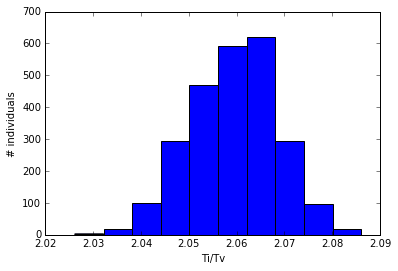

In [12]:
def calculate_titv(G):
    expr = G.apply("alt_copies", "iif(allele_1,1,0)+ iif(allele_2,1,0)")
    expr = sdb.merge(expr, SNP['is_transition'])
    expr = expr.apply("ti", "iif(is_transition, alt_copies, 0)", \
                          "tv", "iif(not is_transition, alt_copies, 0)").\
            aggregate("sum(ti) as ti, sum(tv) as tv", "sample_id").\
            eval()
    return expr

titv = calculate_titv(GENOTYPE).todataframe()

plt.hist(titv['ti']/titv['tv'])
plt.title("")
plt.xlabel("Ti/Tv")
plt.ylabel("# individuals")
plt.show()

All the data traversal is performed by SciDB in parallel; then the histogram buckets and counts are imported into Python memory for plotting. Note that lazily-evaluated subexpressions can be stored, composed, and reused as Python variables. This is often a lot nicer than formulating SQL!

We can also calculate Ti/Tv for just one individual, by filtering the input matrix:

In [13]:
titv1 = calculate_titv(
    sdb.merge(
        GENOTYPE, 
        sdb.afl.filter(SAMPLE['sample'], "sample = 'HG03209'")
    )
    ).todataframe()
titv1['ti']/titv1['tv']

sample_id
1234    2.056302
dtype: float64

## Principal component analysis

Now let's find principal components of the genotype data and project the individual genomes onto them, revealing the underlying population structure. Begin by selecting common SNPs, because rare variants inherently don't contribute much to the overall variance.

Select all variants whose af is greater than `min_af` and less than `max_af`; if variant_limit is
specified, then select up to that many variants, chosen randomly. 

In [14]:
min_af = 0.1
max_af = 0.9
chunk_size=512
#variant_limit = 4

t0 = time.time()
KG_CHROMOSOME = sdb.wrap_array("KG_CHROMOSOME")
KG_VARIANT    = sdb.wrap_array("KG_VARIANT")
KG_GENOTYPE   = sdb.wrap_array("KG_GENOTYPE")
KG_SAMPLE     = sdb.wrap_array("KG_SAMPLE")

KG_POPULATION = sdb.wrap_array("KG_POPULATION")
#selected_variants = dimension_rename(project(unpack(subset(KG_VARIANT, sprintf("af>%f and af<%f", 
#  min_af, max_af))), c("chromosome_id, start, end, alternate_id")), old="i", new="dense_variant_id")
selected_variants = KG_VARIANT.filter("af>%f and af<%f" % (min_af, max_af))\
                                .unpack()\
                                .project("chromosome_id, start, end, alternate_id")\
                                .dimension_rename('idx', 'dense_variant_id')

if 'variant_limit' in locals() or 'variant_limit' in globals():
    selected_variants = selected_variants.apply("randomizer", "random()")\
                                            .sort("randomizer asc")\
                                            .between(0, variant_limit-1)\
                                            .dimension_rename('n', 'dense_variant_id')
    
selected_variants = selected_variants.eval()
num_variants = selected_variants.nonempty()
num_samples = KG_SAMPLE.nonempty()
print("%f %f: Found %i variants that fit the criteria; running [%i x %i]" %
              ((time.time()-t0), (time.time()-t0), num_variants, num_variants, num_samples))


7.890002 7.890003: Found 701434 variants that fit the criteria; running [701434 x 2504]


The redimension operation just removes some unneeded attributes and dimensions, and retains the newly formulated `dense_variant_id` as the only attribute.

In [15]:
t1=time.time()
redim_guide = selected_variants.redimension("<dense_variant_id:int64> \
        [chromosome_id=0:*,1,0,start=0:*,10000000,0,end=0:*,10000000,0,alternate_id=0:19,20,0]")
#        scidb:::build_dim_schema(KG_VARIANT)))

Now construct a matrix `G` (or `redim_matrix` below) where `G[i,j]` is the number of copies of the alt allele found in sample `i`, common SNP `j`. The samples are observations, and the SNPs are variables. Reference: doi:10.1371/journal.pgen.0020190

The array has the schema: `<value> [sample_id, variant_number]` where value is 2 if the variant is present in both alleles, 1 if the variant is present in one allele or 0 otherwise. 

Due to the `merge()` operation, the dimension of this array is equal to number of samples times the number of selected variants. 

In [16]:
redim_matrix = KG_GENOTYPE.apply("v", "double(iif(allele_1 and allele_2, 2.0, iif(allele_1 or allele_2, 1.0, 0.0)))")
redim_matrix = sdb.merge(redim_matrix, redim_guide)
redim_matrix = redim_matrix.redimension("<v:double null> [sample_id = 0:%i,%i,0, dense_variant_id=0:%i,%i,0]" % 
                                                 (num_samples-1, chunk_size, num_variants-1, chunk_size))\
                            .substitute("double(nan)")\
                            .eval()
print("%f %f: Built matrix" % ((time.time()-t0), (time.time()-t1)))

2002.144144 1994.249701: Built matrix


Normalize each variable according to the equation:

> $M(i,j) =       \frac{C(i,j) - u(j)}{\sqrt{p(j)(1-p(j))}}$
         
where:

> $u(j)$ is the column-wise mean,

> $p(j) = u(j)/2$, is an estimate of the underlying allele frequency (autosomal data)

First, sweep out the column means. 

**NOTE**: It is instructive to note the AFL queries generated by the numPy like syntax below. Try it yourself e.g. run: 

`redim_matrix.mean(0).query`

In [17]:
t1=time.time()
centered1 = redim_matrix - redim_matrix.mean(0)
centered1 = centered1.eval()
print("%f %f: Centered" % ((time.time()-t0), (time.time()-t1)))

2376.528635 374.373229: Centered


Next, normalize each variable. We do the first step explicitly using AFL like syntax

In [18]:
denom = redim_matrix.aggregate('avg(v)', 'dense_variant_id')\
            .apply('denom', '1/pow(v_avg/2*(1-v_avg/2),0.5)')\
            .project('denom')
centered = centered1 / denom \
                .eval()

## Calculate covariance


Compute the sample covariance matrix ("economy-sized", since we have many more variables than observations).

Next, download to a numPy array and display the covariance.

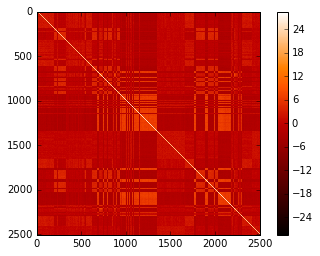

In [19]:
CV1 = (sdb.dot(centered, centered.T)/(centered.shape[0]-1))
CV = CV1.toarray()
io.imshow(CV, cmap='gist_heat')
io.show()

Both axes above are simply the 2,504 samples in the phase 3 data. The observed correlation structure probably just reflects how the 1000 Genomes project added sample batches of various ethnicities over time.

Now perform SVD on the covariance matrix

In [20]:
t1=time.time()
svded = sdb.afl.gesvd("%s, 'left'" % CV1.name)\
            .eval()
print("%f %f: SVD Computed" % ((time.clock()-t0), (time.clock()-t1)))
download = svded[:, 0:3].toarray()

-1459439865.045241 -1459444099.103610: SVD Computed


Next plot the projection of the observations (individuals) onto the first three principal components:

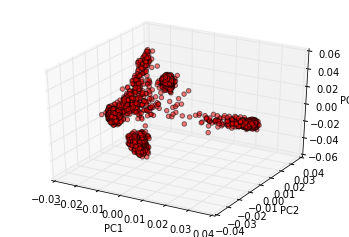

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =download[:,0]
y =download[:,1]
z =download[:,2]



ax.scatter(x, y, z, c='r', marker='o', alpha =0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()


For the avoidance of doubt: all the matrix calculations here were parallelized in SciDB, not computed by the local Python process. We didn't have to dump a lot of data into any separate system for numerical analysis.

The PCA's interpretation becomes clear if we label the points by the ethnicity of each individual. This also provides an elementary example of joining "phenotypic data". 

First, record the population ID-s from `KG_POPULATION` array

In [22]:
l1, population_id = zip(*KG_POPULATION['population'].todataframe().index.get_values())

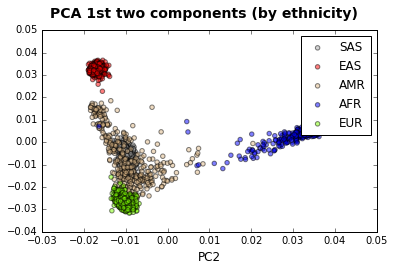

In [23]:
x = download[:,0]
y = download[:,1]
classes = KG_POPULATION.todataframe().population.tolist()

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

# Some processing for the colors
colorbar = ['b', 'burlywood', 'red', 'chartreuse', 'Darkgray']
colours = []
for i in range(len(population_id)):
    colours.append(colorbar[population_id[i]])
    
# Finally the plots per group     
for (i,cla) in enumerate(set(classes)):
    xc = [p for (j,p) in enumerate(x) if classes[j]==cla]
    yc = [p for (j,p) in enumerate(y) if classes[j]==cla]
    cols = [c for (j,c) in enumerate(colours) if classes[j]==cla]
    plt.scatter(xc,yc,c=cols,label=cla, alpha=0.5)
fig.suptitle('PCA 1st two components (by ethnicity)', fontsize=14, fontweight='bold')
ax.set_xlabel('PC1', fontsize=12)
ax.set_xlabel('PC2', fontsize=12)
plt.legend(loc=0)
legend = ax.legend(frameon=True, scatterpoints=1)

plt.show()

### To be done

 - Linkage disequilibrium